# Climate Data Scraping: Merge Ignitions Data with Weather Stations
#### Fire Atlas Dataset + NCDC GSOM + NCDC Monthly Normals

Andrew McDonald // CSE 847 // April 2021

In [24]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from geopy.distance import geodesic

pd.set_option("display.max_rows", 25)

In [42]:
ignitions = pd.read_csv("data/usa_2016_wildfires.csv")
gsom_stations = pd.read_csv("data/ncdc_gsom_stations.csv")
normal_stations = pd.read_csv("data/ncdc_normal_mly_stations.csv")

In [43]:
display(ignitions.head(3))
display(gsom_stations.head(3))
display(normal_stations.head(3))

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,...,direction,direction_,landcover,landcover_,tile_ID,pop_est,continent,name,iso_a3,gdp_md_est
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,...,3,east,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,...,4,southeast,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,...,0,none,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0


,name,dataset,elevation,mindate,maxdate,latitude,datacoverage,id,elevationUnit,longitude
0,"CHEMAINUS, CA",GSOM,75.0,1919-01-01,2021-03-01,48.9333,0.8427,GHCND:CA001011500,METERS,-123.7500
1,"DUNCAN KELVIN CREEK, CA",GSOM,103.0,1987-04-01,2016-02-01,48.7333,0.9885,GHCND:CA001012573,METERS,-123.7333
2,"GALIANO NORTH, CA",GSOM,6.0,1975-02-01,2021-03-01,48.9833,0.8719,GHCND:CA0010130MN,METERS,-123.5667


,name,dataset,elevation,mindate,maxdate,latitude,datacoverage,id,elevationUnit,longitude
0,"PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, US",NORMAL_MLY,3.7,2010-01-01,2010-12-01,-14.33056,1,GHCND:AQW00061705,METERS,-170.71361
1,"CAPITOL HILL 1, US",NORMAL_MLY,197.5,2010-01-01,2010-12-01,15.21553,1,GHCND:CQC00914080,METERS,145.75255
2,"ROTA AIRPORT, US",NORMAL_MLY,179.2,2010-01-01,2010-12-01,14.17170,1,GHCND:CQC00914801,METERS,145.24280


In [45]:
gsom_tree = KDTree(gsom_stations[["latitude", "longitude"]])
_, idx = gsom_tree.query(ignitions[["latitude", "longitude"]], k=1)
ignitions["gsom_station_idx"] = idx

normal_tree = KDTree(normal_stations[["latitude", "longitude"]])
_, idx = normal_tree.query(ignitions[["latitude", "longitude"]], k=1)
ignitions["normal_station_idx"] = idx

In [46]:
gsom_stations.columns = [f"gsom_{col}" for col in gsom_stations.columns]
normal_stations.columns = [f"normal_{col}" for col in normal_stations.columns]
merged = pd.merge(ignitions, gsom_stations,  left_on="gsom_station_idx", right_index=True)
merged = pd.merge(merged, normal_stations,  left_on="normal_station_idx", right_index=True)

with pd.option_context("display.max_columns", None):
    display(merged)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_,landcover,landcover_,tile_ID,pop_est,continent,name,iso_a3,gdp_md_est,gsom_station_idx,normal_station_idx,gsom_name,gsom_dataset,gsom_elevation,gsom_mindate,gsom_maxdate,gsom_latitude,gsom_datacoverage,gsom_id,gsom_elevationUnit,gsom_longitude,normal_name,normal_dataset,normal_elevation,normal_mindate,normal_maxdate,normal_latitude,normal_datacoverage,normal_id,normal_elevationUnit,normal_longitude
0,1,20.8438,-156.4130,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861
1,2,20.8396,-156.4180,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861
2,3,20.8105,-156.4370,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861
3,4,20.6271,-156.2470,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3144,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KULA HOSPITAL 267, HI US",NORMAL_MLY,923.5,2010-01-01,2010-12-01,20.70090,1,GHCND:USC00515004,METERS,-156.35620
4,5,19.8063,-155.8950,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07,326625791,North America,United States of America,USA,18560000.0,4704,3141,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KE AHOLE PT. 68.13, HI US",NORMAL_MLY,6.1,2010-01-01,2010-12-01,19.72810,1,GHCND:USC00513911,METERS,-156.05880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11517,56789,40.8521,-78.1691,0.43,2.78,2016-04-14,105,2016-04-14,105,1,0.43,0.93,0.46,0,none,4,Deciduous Broadleaf forest,h12v04,326625791,North America,United States of America,USA,18560000.0,3168,2204,"PHILIPSBURG 2 S, PA US",GSOM,524.3,1998-04-01,2021-03-01,40.87291,0.9927,GHCND:USC00366921,METERS,-78.21615,"PHILIPSBURG 2 S, PA US",NORMAL_MLY,524.3,2010-01-01,2010-12-01,40.87291,1,GHCND:USC00366921,METERS,-78.21615
11518,56790,40.4188,-76.7056,0.64,3.70,2015-11-14,318,2015-11-14,318,1,0.64,1.39,0.64,0,none,5,Mixed forest,h12v04,326625791,North America,United States of America,USA,18560000.0,3117,3314,"DEHART DAM, PA US",GSOM,163.7,1998-05-01,2021-03-01,40.46093,0.8872,GHCND:USC00362071,METERS,-76.74870,"MIDDLETOWN HARRISBURG INTERNATIONAL AIRPORT, P...",NORMAL_MLY,95.1,2010-01-01,2010-12-01,40.19620,1,GHCND:USW00014711,METERS,-76.77240
11519,56791,40.0271,-74.4895,0.86,4.63,2016-06-26,178,2016-07-04,186,9,0.10,0.21,0.41,7,west,4,Deciduous Broadleaf forest,h12v04,326625791,North America,United States of America,USA,18560000.0,2520,1649,"HIGHTSTOWN 2 W, NJ US",GSOM,30.5,1893-01-01,2021-03-01,40.26639,0.9526,GHCND:USC00283951,METERS,-74.56417,"PEMBERTON, NJ US",NORMAL_M

In [47]:
merged["distance_from_gsom"] = 0
merged["distance_from_normal"] = 0
for i, row in merged.iterrows():
    fire = (row["latitude"], row["longitude"])
    gsom_station = (row["gsom_latitude"], row["gsom_longitude"])
    normal_station = (row["normal_latitude"], row["normal_longitude"])
    merged.loc[i, "distance_from_gsom"] = geodesic(fire, gsom_station).km
    merged.loc[i, "distance_from_normal"] = geodesic(fire, normal_station).km

In [48]:
with pd.option_context("display.max_columns", None):
    display(merged)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_,landcover,landcover_,tile_ID,pop_est,continent,name,iso_a3,gdp_md_est,gsom_station_idx,normal_station_idx,gsom_name,gsom_dataset,gsom_elevation,gsom_mindate,gsom_maxdate,gsom_latitude,gsom_datacoverage,gsom_id,gsom_elevationUnit,gsom_longitude,normal_name,normal_dataset,normal_elevation,normal_mindate,normal_maxdate,normal_latitude,normal_datacoverage,normal_id,normal_elevationUnit,normal_longitude,distance_from_gsom,distance_from_normal
0,1,20.8438,-156.4130,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861,128.450424,6.400746
1,2,20.8396,-156.4180,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861,128.162642,6.747153
2,3,20.8105,-156.4370,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3400,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KAHULUI AIRPORT, HI US",NORMAL_MLY,15.5,2010-01-01,2010-12-01,20.89972,1,GHCND:USW00022516,METERS,-156.42861,125.720919,9.916521
3,4,20.6271,-156.2470,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06,326625791,North America,United States of America,USA,18560000.0,4704,3144,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KULA HOSPITAL 267, HI US",NORMAL_MLY,923.5,2010-01-01,2010-12-01,20.70090,1,GHCND:USC00515004,METERS,-156.35620,100.848205,14.008401
4,5,19.8063,-155.8950,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07,326625791,North America,United States of America,USA,18560000.0,4704,3141,"KAILUA KONA KE AHOLE AIRPORT, HI US",GSOM,13.1,1998-01-01,2021-03-01,19.73556,0.9858,GHCND:USW00021510,METERS,-156.04889,"KE AHOLE PT. 68.13, HI US",NORMAL_MLY,6.1,2010-01-01,2010-12-01,19.72810,1,GHCND:USC00513911,METERS,-156.05880,17.928047,19.225533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11517,56789,40.8521,-78.1691,0.43,2.78,2016-04-14,105,2016-04-14,105,1,0.43,0.93,0.46,0,none,4,Deciduous Broadleaf forest,h12v04,326625791,North America,United States of America,USA,18560000.0,3168,2204,"PHILIPSBURG 2 S, PA US",GSOM,524.3,1998-04-01,2021-03-01,40.87291,0.9927,GHCND:USC00366921,METERS,-78.21615,"PHILIPSBURG 2 S, PA US",NORMAL_MLY,524.3,2010-01-01,2010-12-01,40.87291,1,GHCND:USC00366921,METERS,-78.21615,4.590851,4.590851
11518,56790,40.4188,-76.7056,0.64,3.70,2015-11-14,318,2015-11-14,318,1,0.64,1.39,0.64,0,none,5,Mixed forest,h12v04,326625791,North America,United States of America,USA,18560000.0,3117,3314,"DEHART DAM, PA US",GSOM,163.7,1998-05-01,2021-03-01,40.46093,0.8872,GHCND:USC00362071,METERS,-76.74870,"MIDDLETOWN HARRISBURG INTERNATIONAL AIRPORT, P...",NORMAL_MLY,95.1,2010-01-01,2010-12-01,40.19620,1,GHCND:USW00014711,METERS,-76.77240,5.937829,25.361543
11519,56791,40.0271,-74.4895,0.86,4.63,2016-06-26,178,2016-07-04,186,9,0.10,0.21,0.41,7,west,4,Deciduous Broadleaf forest,h12v04,326625791,North Americ

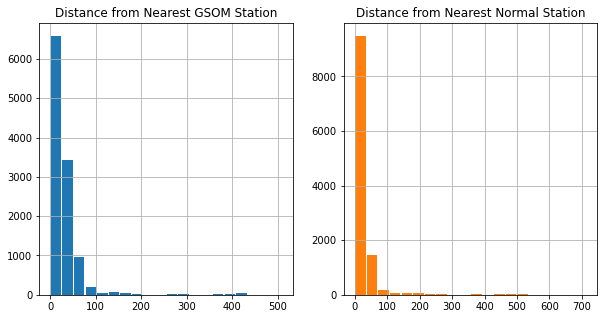

In [52]:
# sanity check distances from nearest wx station
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
merged["distance_from_gsom"].hist(ax=ax[0], bins=20, rwidth=0.9, color=plt.cm.tab10(0))
ax[0].set_title("Distance from Nearest GSOM Station")
merged["distance_from_normal"].hist(ax=ax[1], bins=20, rwidth=0.9, label="Normal", color=plt.cm.tab10(1))
ax[1].set_title("Distance from Nearest Normal Station")
plt.show()

In [53]:
merged[["distance_from_gsom", "distance_from_normal"]].describe()

,distance_from_gsom,distance_from_normal
count,11524.000000,11524.000000
mean,33.468203,32.626832
std,45.639084,56.473046
min,0.379057,0.227078
25%,15.062916,14.554114
50%,22.937375,21.246689
75%,36.623987,30.719502
max,509.270105,713.543936


In [55]:
# check to see where fires far from stations are occurring
# mostly alaska: leave entries intact, as a model will be able to use distance
# from station as a proxy of climate data reliability
merged[(merged["distance_from_gsom"] > 200) | (merged["distance_from_normal"] > 20)]

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,...,normal_elevation,normal_mindate,normal_maxdate,normal_latitude,normal_datacoverage,normal_id,normal_elevationUnit,normal_longitude,distance_from_gsom,distance_from_normal
5,6,42.2438,-121.8750,0.86,5.56,2016-08-09,222,2016-08-09,222,1,...,1274.1,2010-01-01,2010-12-01,42.70360,1,GHCND:USC00351574,METERS,-121.99520,16.729942,52.023368
1259,7183,42.8104,-121.5540,1.07,5.56,2016-06-06,158,2016-06-16,168,11,...,1274.1,2010-01-01,2010-12-01,42.70360,1,GHCND:USC00351574,METERS,-121.99520,38.015993,38.015993
6,7,42.2313,-121.8730,0.64,4.63,2016-08-16,229,2016-08-18,231,3,...,1230.8,2010-01-01,2010-12-01,41.95999,1,GHCND:USC00049053,METERS,-121.47449,15.380113,44.665475
12,13,41.6896,-121.9290,0.21,1.85,2016-08-05,218,2016-08-05,218,1,...,1453.9,2010-01-01,2010-12-01,41.70190,1,GHCND:USC00044838,METERS,-121.50110,45.032495,35.646366
13,14,41.6771,-121.8220,0.21,1.85,2016-06-21,173,2016-06-21,173,1,...,1453.9,2010-01-01,2010-12-01,41.70190,1,GHCND:USC00044838,METERS,-121.50110,26.857272,26.857272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11512,56784,41.2188,-75.1547,14.15,26.85,2016-04-13,104,2016-04-24,115,12,...,143.6,2010-01-01,2010-12-01,41.01478,1,GHCND:USC00368596,METERS,-75.20712,23.081443,23.081443
11513,56785,41.2188,-75.1381,1.29,6.48,2016-04-13,104,2016-04-22,113,10,...,143.6,2010-01-01,2010-12-01,41.01478,1,GHCND:USC00368596,METERS,-75.20712,23.387445,23.387445
11514,56786,41.2104,-75.1451,0.43,2.78,2016-04-13,104,2016-04-13,104,1,...,143.6,2010-01-01,2010-12-01,41.01478,1,GHCND:USC00368596,METERS,-75.20712,22.340590,22.340590
11516,56788,40.9604,-76.3992,1.50,7.41,2016-04-13,104,2016-04-15,106,3,...,128.0,2010-01-01,2010-12-01,40.78310,1,GHCND:USC00367931,METERS,-76.86170,6.634483,43.677435


In [56]:
# final check on shape
merged.shape

(11524, 47)

In [57]:
# save merged table
merged.to_csv("data/usa_2016_wildfires_stations.csv", index=False)